## **Importar bibliotecas**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import zipfile

from glob import glob
from google.colab import drive

DOWNLOAD_DATASET = False
CREATE_MODEL = False
TRAIN_MODEL = False

## **Baixar dataset tsukuba (https://home.cvlab.cs.tsukuba.ac.jp/dataset)**


In [ ]:
# baixa dataset
if DOWNLOAD_DATASET:
  !pip install gdown
  !gdown --id 143OsIIPUDVRsUT8NF2I7MidehK_m4-U- -O /content/drive/MyDrive/TCC/tsukuba.zip

  local_zip = '/content/drive/MyDrive/TCC/tsukuba.zip'

  zip_ref = zipfile.ZipFile(local_zip, 'r')

  zip_ref.extractall('/content/drive/MyDrive/TCC')
  zip_ref.close()
else:
  drive.mount("/content/drive")

# Define diretório onde se encontram as imagens
left_image_path = '/content/drive/MyDrive/TCC/TsukubaStereo/images/left'
right_image_path = '/content/drive/MyDrive/TCC/TsukubaStereo/images/right'
disp_image_path = '/content/drive/MyDrive/TCC/TsukubaStereo/disparity/left'

# Escolhe tipos de arquivos desejados
glob_left_imgs = os.path.join(left_image_path, '*.png')
glob_right_imgs = os.path.join(right_image_path, '*.png')
glob_disp_imgs = os.path.join(disp_image_path, '*.png')

# Cria lista dos nomes dos arquivos
left_img_paths = glob(glob_left_imgs)
right_img_paths = glob(glob_right_imgs)
disp_img_paths = glob(glob_disp_imgs)

# Ordena lista dos arquivos
left_img_paths.sort()
right_img_paths.sort()
disp_img_paths.sort()

Mounted at /content/drive


## **Preparação dos dados**

### **Gerador de dados**

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

# Gerador para treino e validação
def batch_generator(left_img_paths, right_img_paths, disp_img_paths, img_size, m_exemplos, batchsize):
    # Inicializa loop infinito que termina no final do treinamento
    while True:
        
        # Loop para selecionar imagens de cada lote
        for start in range(0, m_exemplos, batchsize):
           
            # Inicializa lista de imagens com máscara e sem máscara
            batch_left_img, batch_right_img, batch_disp_img = [], [], []
        
            end = min(start + batchsize, m_exemplos)
            for i in range(start, end):
                # Carrega images e o mapa de disparidade
                left_imagem = load_img(left_img_paths[i])
                right_imagem = load_img(right_img_paths[i])
                disp_imagem = load_img(disp_img_paths[i])
                
                # Converet para tensor 
                left_imagem = img_to_array(left_imagem)
                right_imagem = img_to_array(right_imagem)
                disp_imagem = img_to_array(disp_imagem)

                # Elimina 4o canal
                left_imagem = left_imagem[:,:,:3]
                right_imagem = right_imagem[:,:,:3]
                
                # Redimensiona imagens e normaliza
                left_imagem = tf.image.resize(left_imagem, img_size)/255.
                right_imagem = tf.image.resize(right_imagem, img_size)/255.
                disp_imagem = tf.image.resize(disp_imagem, img_size)/255.
                disp_imagem = disp_imagem[:,:,0]
                disp_imagem = np.max(disp_imagem, axis=0) # Ajustado para pegar a maior disparidade de cada coluna

                # Adiciona imagem original e segmentada aos lotes
                batch_left_img.append(left_imagem)
                batch_right_img.append(right_imagem)
                batch_disp_img.append(disp_imagem)

            yield [np.stack(batch_left_img, axis=0), np.stack(batch_right_img, axis=0)], np.stack(batch_disp_img, axis=0)

In [ ]:
def batch_generator_eval(left_img_paths, right_img_paths, disp_img_paths, img_size, m_exemplos, batchsize):
    # Inicializa loop infinito que termina no final do treinamento
    while True:
        
        # Loop para selecionar imagens de cada lote
        for start in range(0, m_exemplos, batchsize):
           
            # Inicializa lista de imagens com máscara e sem máscara
            batch_left_img, batch_right_img, batch_disp_img, max_disp_imagem_batch = [], [], [], []
        
            end = min(start + batchsize, m_exemplos)
            for i in range(start, end):
                # Carrega images e o mapa de disparidade
                left_imagem = load_img(left_img_paths[i])
                right_imagem = load_img(right_img_paths[i])
                disp_imagem = load_img(disp_img_paths[i])
                
                # Converet para tensor 
                left_imagem = img_to_array(left_imagem)
                right_imagem = img_to_array(right_imagem)
                disp_imagem = img_to_array(disp_imagem)

                # Elimina 4o canal
                left_imagem = left_imagem[:,:,:3]
                right_imagem = right_imagem[:,:,:3]
                
                # Redimensiona imagens e normaliza
                left_imagem = tf.image.resize(left_imagem, img_size)/255.
                right_imagem = tf.image.resize(right_imagem, img_size)/255.
                disp_imagem = tf.image.resize(disp_imagem, img_size)/255.
                disp_imagem = disp_imagem[:,:,0]
                max_disp_imagem = np.max(disp_imagem, axis=0) # Ajustado para pegar a maior disparidade de cada coluna

                # Adiciona imagem original e segmentada aos lotes
                batch_left_img.append(left_imagem)
                batch_right_img.append(right_imagem)
                batch_disp_img.append(disp_imagem)
                max_disp_imagem_batch.append(max_disp_imagem)

            yield [np.stack(batch_left_img, axis=0), np.stack(batch_right_img, axis=0)], np.stack(batch_disp_img, axis=0), np.stack(max_disp_imagem_batch, axis=0)

### **Separa dados de teste e treinamento**

In [ ]:
from sklearn.utils import shuffle

left_img_paths, right_img_paths, disp_img_paths = shuffle(left_img_paths, right_img_paths, disp_img_paths)

# Conjunto de dados de treinamento
train_left_img_paths = left_img_paths[:1500]
train_right_img_paths = right_img_paths[:1500]
train_disp_img_paths = disp_img_paths[:1500]

# Conjunto de dados de validação
val_left_img_paths = left_img_paths[1500:]
val_right_img_paths = right_img_paths[1500:]
val_disp_img_paths = disp_img_paths[1500:]

In [ ]:
m_train = len(train_left_img_paths)
m_val = len(val_left_img_paths)

# Dimensão desejada para as imagens
img_size = (120, 160)

# Define tamanho do lote
batch_size = 64

# Calcula números de lotes por época
train_steps = len(train_left_img_paths) // batch_size
val_steps = len(val_left_img_paths) // batch_size

## **Criar modelo**

In [ ]:
if CREATE_MODEL:
  from tensorflow.keras.models import Model, Sequential
  from tensorflow.keras.layers import Input, Activation
  from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Dense
  from tensorflow.keras.layers import concatenate, BatchNormalization

  # Define dimensão das imagens de entrada
  input_shape = (120, 160, 3)

  #### Rede de extração de características ####
  rna_carac = Sequential()

  rna_carac.add(Conv2D(32, (3,3), padding='same', activation='linear', use_bias=False, input_shape=input_shape))
  rna_carac.add(BatchNormalization())
  rna_carac.add(Activation('relu'))
  rna_carac.add(MaxPooling2D(2,2))

  rna_carac.add(Conv2D(64, (3,3), padding='same', activation='linear', use_bias=False))
  rna_carac.add(BatchNormalization())
  rna_carac.add(Activation('relu'))
  rna_carac.add(MaxPooling2D(2, 2))

  rna_carac.add(Conv2D(128, (3,3), padding='same', activation='linear', use_bias=False))
  rna_carac.add(BatchNormalization())
  rna_carac.add(Activation('relu'))

  rna_carac.add(Conv2D(256, (3,3), padding='same', activation='linear', use_bias=False))
  rna_carac.add(BatchNormalization())
  rna_carac.add(Activation('relu'))

  rna_carac.summary()

In [ ]:
if CREATE_MODEL:
  #### Rede de calculo da profundidade ####
  # Define entradas
  input_left = tf.keras.layers.Input(shape=input_shape)
  input_right = tf.keras.layers.Input(shape=input_shape)

  # Processa imagens para gerar as características
  carac_left = rna_carac(input_left)
  carac_right = rna_carac(input_right)

  # Une os vetores de características
  x1 = concatenate([carac_left, carac_right], axis=3)
                                    
  # Aplica convolução
  x2 = Conv2D(256, (3,3), padding='same', activation='relu', strides=(2,2))(x1)
  x3 = Dropout(0.2)(x2)
  x4 = Conv2D(128, (3,3), padding='same', activation='relu', strides=(2,2))(x3)
  x5 = Dropout(0.2)(x4)
  x6 = Flatten()(x5)
  x7 = Dense(256, activation='relu')(x6)
  x8 = Dropout(0.2)(x7)
  x9 = Dense(160, activation='relu')(x8)

  # cria rede siamesa
  rna_stereo = Model([input_left, input_right], x9)

  # Apresenta sumario
  rna_stereo.summary()

In [ ]:
if TRAIN_MODEL:

  from tensorflow.keras import optimizers

  # Configura otimizador
  adam = optimizers.Adam(lr=0.001)
  rna_stereo.compile(optimizer=adam, loss='mse', metrics=['mae'])

## **Carregar modelo**

In [ ]:
if not CREATE_MODEL:
  from tensorflow.keras.models import load_model
  rna_stereo = load_model("/content/drive/MyDrive/TCC/rna_stereo_norm.h5")
  rna_stereo.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 30, 40, 256)  389856      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 30, 40, 512)  0           sequential[0][0]           

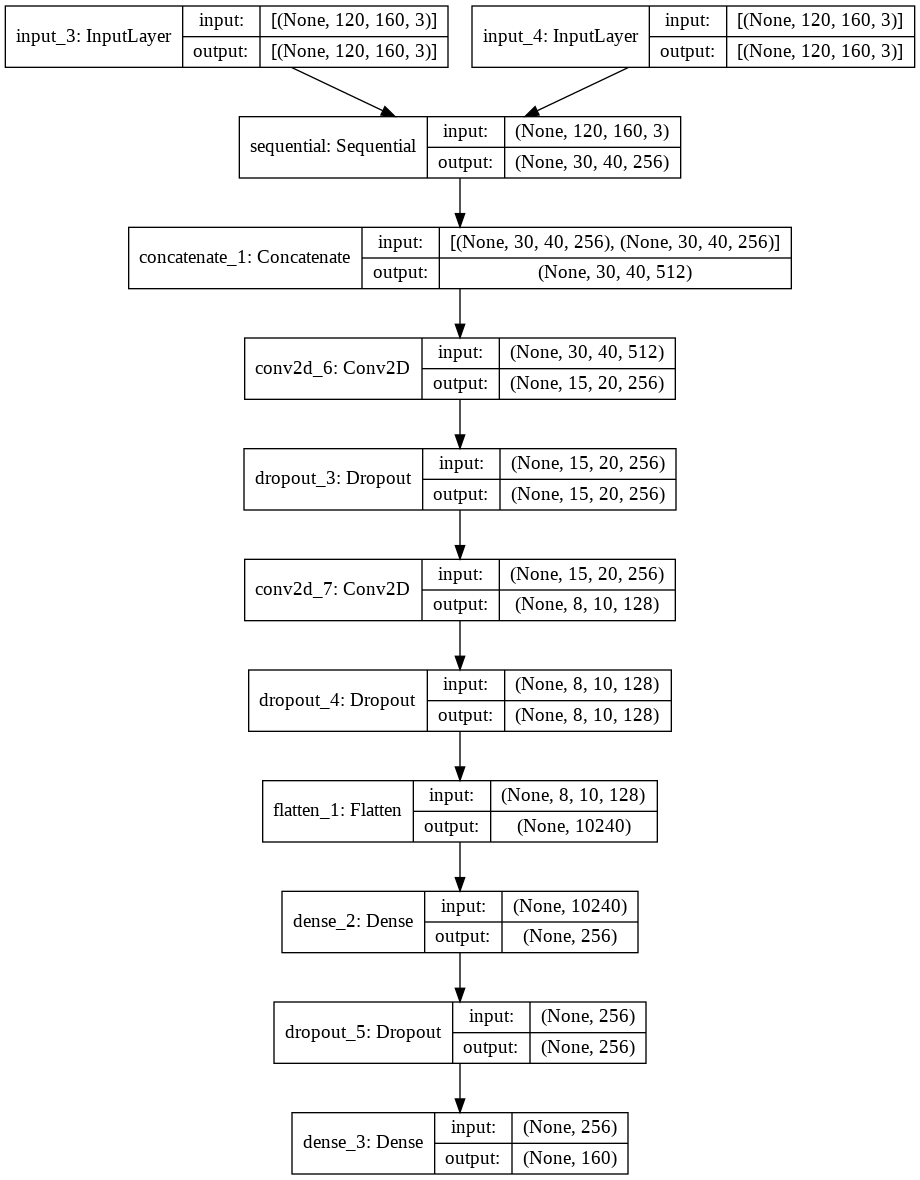

In [ ]:
# Gera um esquema gráfico da rede
from tensorflow.keras.utils import plot_model
plot_model(rna_stereo, show_shapes=True)

## **Treinar modelo**

In [ ]:
if TRAIN_MODEL:
  from tensorflow.keras.callbacks import ModelCheckpoint

  # Define o callback para salvar os parâmetros
  checkpointer = ModelCheckpoint('/content/drive/MyDrive/TCC/rna_stereo_norm.h5', verbose=1, save_best_only=True)

  # Treinamento da rede
  results = rna_stereo.fit(
            batch_generator(train_left_img_paths, train_right_img_paths, train_disp_img_paths, img_size, m_train, batchsize=batch_size),
            steps_per_epoch=train_steps, 
            epochs=200,
            validation_data=batch_generator(val_left_img_paths, val_right_img_paths, val_disp_img_paths, img_size, m_val, batchsize=batch_size),
            validation_steps=val_steps,
            initial_epoch=150,
            callbacks=[checkpointer],
            verbose=1)

## **Avaliar resultados**

In [ ]:
if TRAIN_MODEL:

  results_dict = results.history

  custo = results_dict['loss']
  mae = results_dict['mae']
  val_custo = results_dict['val_loss']
  val_mae = results_dict['val_mae']

  epocas = range(1, len(custo) + 1)

  plt.plot(epocas, custo, 'b', label='Custo - treinamento')
  plt.plot(epocas, val_custo, 'r', label='Custo - validação')
  plt.title('Valor da função de custo – treinamento e validação')
  plt.xlabel('Épocas')
  plt.ylabel('Custo')
  plt.legend()
  plt.show()

  plt.plot(epocas, mae, 'b', label='MAE - treinamento')
  plt.plot(epocas, val_mae, 'r', label='MAE - validação')
  plt.title('Valor da métrica – treinamento e validação')
  plt.xlabel('Épocas')
  plt.ylabel('MAE')
  plt.legend()
  plt.show()

In [ ]:
if TRAIN_MODEL:
  custo_metrica_train = rna_stereo.evaluate(batch_generator(train_left_img_paths, train_right_img_paths, train_disp_img_paths, img_size, m_train, batchsize=batch_size), steps=train_steps)
  custo_metrica_val = rna_stereo.evaluate(batch_generator(val_left_img_paths, val_right_img_paths, val_disp_img_paths, img_size, m_val, batchsize=batch_size), steps=val_steps)

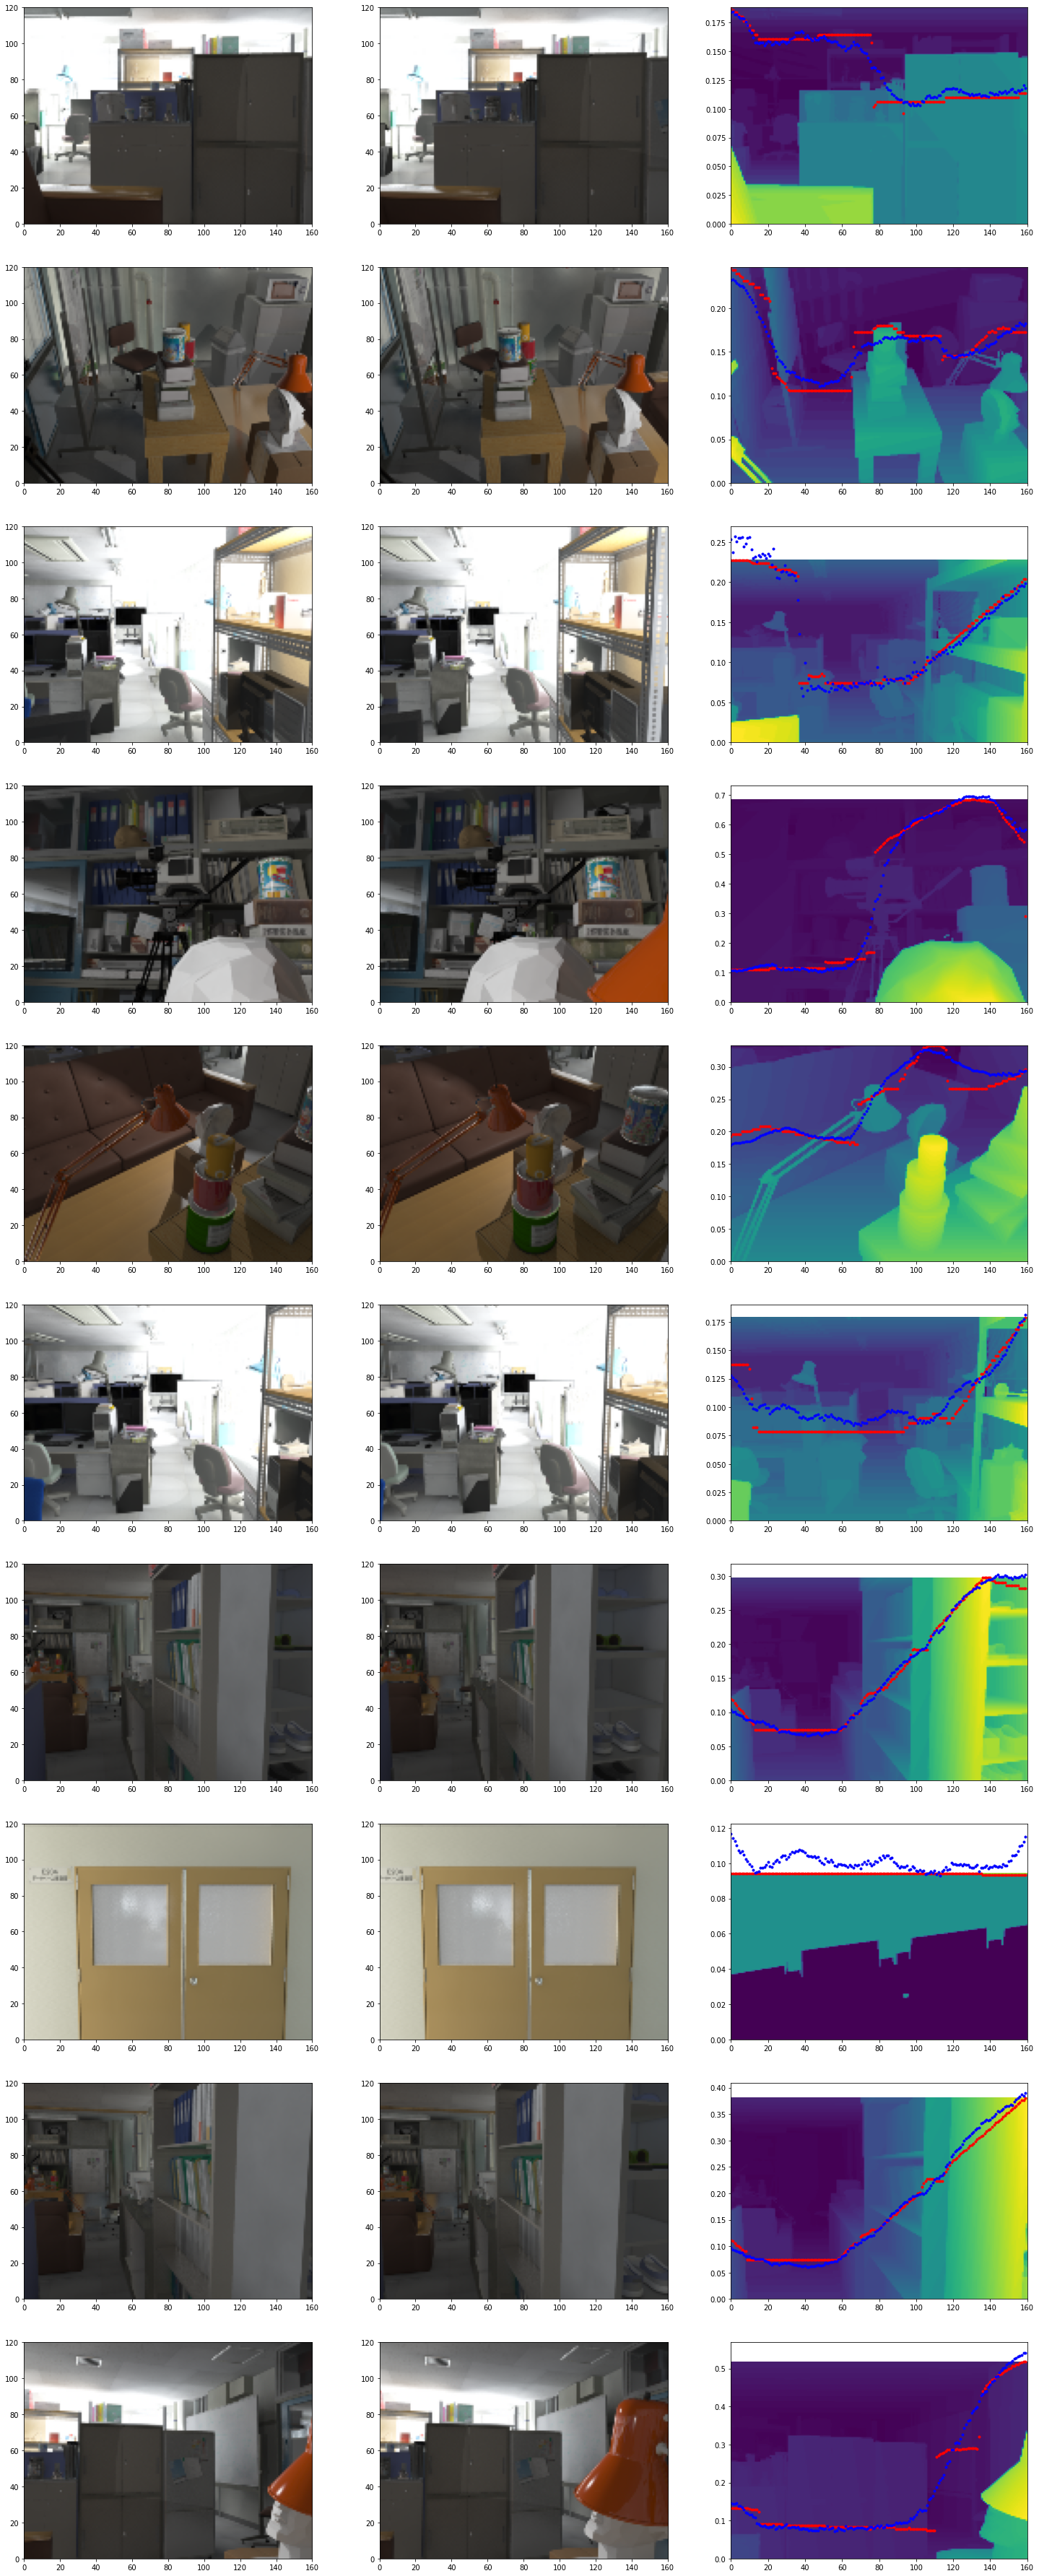

In [ ]:
# Instancia o gerador de dados de validação
exemplos=10

datagen = batch_generator_eval(val_left_img_paths, val_right_img_paths, val_disp_img_paths, img_size, m_val, batchsize=exemplos)

# Gera lote de exemplos de valiação
[left_img_batch, right_img_batch], disp_img_batch, max_disp_imagem_batch = next(datagen) 

# Calcula previsão da rede para o lote de validação gerado
y_prev_batch = rna_stereo.predict([left_img_batch, right_img_batch])

index = 0
figure, axis = plt.subplots(10, 3, figsize=(25, 65))

for i in range(exemplos):
  left_img = left_img_batch[index]
  right_img = right_img_batch[index]
  disp_img = disp_img_batch[index]
  max_disp_imagem = max_disp_imagem_batch[index]
  y_prev = y_prev_batch[index]

  left_img = np.squeeze(left_img)
  right_img = np.squeeze(right_img)

  axis[i, 0].imshow(left_img, extent=[0, 160, 0, 120])
  axis[i, 1].imshow(right_img, extent=[0, 160, 0, 120])
  axis[i, 2].imshow(disp_img, extent=[0, 160, 0, np.max(max_disp_imagem)], aspect='auto')
  axis[i, 2].plot(max_disp_imagem, 'r.')
  axis[i, 2].plot(y_prev, 'b.')

  index+=1

In [ ]:
def plotDisp(index):
  plt.figure(figsize=(7, 4))
  plt.plot(max_disp_imagem_batch[index], 'ro', label='Disp. real')
  plt.plot(y_prev_batch[index], 'bo', label='Disp. prevista')
  plt.title('Disp. real e prevista')
  plt.xlabel('Coluna')
  plt.ylabel('Disp.')
  plt.legend()
  plt.show

Menor disparidade: 0.10273381
Maior disparidade: 0.18494278



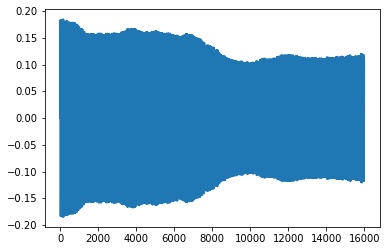

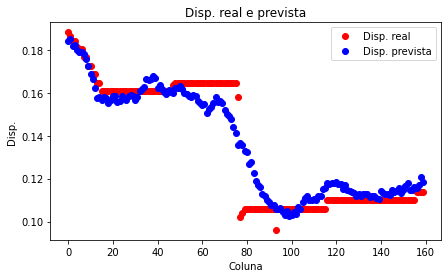

In [ ]:
from IPython.display import Audio
import numpy as np
from math import pi

def getFreq(disp):
  return int(1000-((1-disp)*1000))+200

index=0

# Taxa de amostragem
sample_rate = 16000

# Duração do em segundos
time = 1

# Taxa de amostragem * duração
srd = sample_rate * time

# gera intervalo para cada coluna da imagem
t = np.linspace(0, time/(sample_rate/160), int((sample_rate*time)/160))
x = []

disparidade = np.zeros(srd)
count = 0
for i in range(160):
  
  # disparidade da coluna
  disp = y_prev_batch[index][i]
  
  # é atribuido uma frequencia em Hz para cada coluna da imagem de acordo com a disparidade
  xx = np.sin(2 * pi * getFreq(disp) * t)
  
  # concatena as frequencias de cada coluna
  x = np.concatenate((x,xx),axis=0)       
  
  # replica a disparidade de cada coluna a fim de preencher igualmente o intervalo da taxa de amostragem
  for j in range(0,int(srd/160)):
    disparidade[count] = disp
    count += 1

# multiplica a disparidade pela frequencia
x = np.multiply(x,disparidade)

# Exibe resultados
print("Menor disparidade: " + str(np.min(y_prev_batch[index])))
print("Maior disparidade: " + str(np.max(y_prev_batch[index])))
print("")
plt.plot(x)
plotDisp(index)
Audio(x, rate=sample_rate, autoplay=True)

In [ ]:
!pip install pydub
!pip install simpleaudio

     |████████████████████████████████| 2.0 MB 14.2 MB/s 
  Created wheel for simpleaudio: filename=simpleaudio-1.0.4-cp37-cp37m-linux_x86_64.whl size=2065948 sha256=2c4a65804bf58517dcafe1dc42191b5a34ba90727b31d90112331a2facd1dfd4
  Stored in directory: /root/.cache/pip/wheels/9a/d6/39/e26b6f988cc5acd1fba2c1b18f0debe27bdee3e1e53f4c93f9
Successfully built simpleaudio


In [ ]:
from pydub import AudioSegment
from pydub.playback import play
from pydub.generators import Sine

In [ ]:
# Create an empty AudioSegment
result = AudioSegment.silent(duration=0)
# Loop over 0-14
for n in range(15):
    # Generate a sine tone with frequency 200 * n
    gen = Sine(200 * n)
    # AudioSegment with duration 200ms, gain -3
    sine  = gen.to_audio_segment(duration=200).apply_gain(-3)
    # Fade in / out
    sine = sine.fade_in(50).fade_out(100)
    # Append the sine to our result
    result += sine
# Play the result
result.export("teste.wav", format="wav")

<_io.BufferedRandom name='teste.wav'>

In [ ]:
from IPython.display import Audio
from pydub.generators import Sine

result = AudioSegment.silent(duration=0)
#teste = AudioSegment.from_file("fanfare_x.wav")
index=0

for i in range(160):
  # disparidade da coluna
  disp = y_prev_batch[index][i]
  gen = Sine(255 * disp)
  # Sine with duration 200ms, gain -3
  sine  = gen.to_audio_segment(duration=10)
  # Fade in / out
  #sine = sine.fade_in(50).fade_out(100)
  # Append the sine to our result
  result += sine

#result = result.overlay(teste)

# Play the result
result.export("teste2.wav", format="wav")
Audio('teste2.wav',autoplay=True)